link : https://www.kaggle.com/code/marlesson/building-a-recommendation-system-using-cnn-v2/comments

* CNN을 활용 한 패션 임베딩  
* 유사한 항목 식별 및 추천에 활용

## 임베딩이란?
높은 차원의 벡터를 변환할 수 있는 낮은 차원의 공간.  
임베딩은 단어 희소 백터와 같이 큰 인풋을 가진 경우에 머신러닝을 쉽게 함.  
이상적으로 임베딩은 임베딩 공간에서 유사한 인풋을 가깝게 배치함으로서 의미를 포착함.  
임베딩은 여러 모델에 걸쳐 학습되고 재사용 될 수 있음.  


따라서 단어 임베딩과 같은 자연어 모델링 기술에서 단어나 구를 상응하는 실제 숫자로 매핑하는 데 사용됨.  
이 벡터 표현은 알고리즘 학습에 의한 처리에 적합할 뿐만 아니라 두 가지 중요하고 유리한 특성을 가지고 있음.  
* Dimensionality Reduction : 표현에 효과적  
* Contextual Similarity : 표현력이 뛰어남


## Data Preparation

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [2]:
DATASET_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/"
print(os.listdir(DATASET_PATH))

['images.csv', 'images', 'styles.csv', 'styles']


In [3]:
df = pd.read_csv(DATASET_PATH + 'styles.csv',nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row : str(row['id']) + ".jpg", axis = 1)
df = df.reset_index(drop=True)
df.head(10)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [4]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH + "/images/" + img

def load_image(img, resized_fac = 0.1):
    img = cv2.imread(img_path(img))
    w,h,_ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)),interpolation = cv2.INTER_AREA)
    return resized

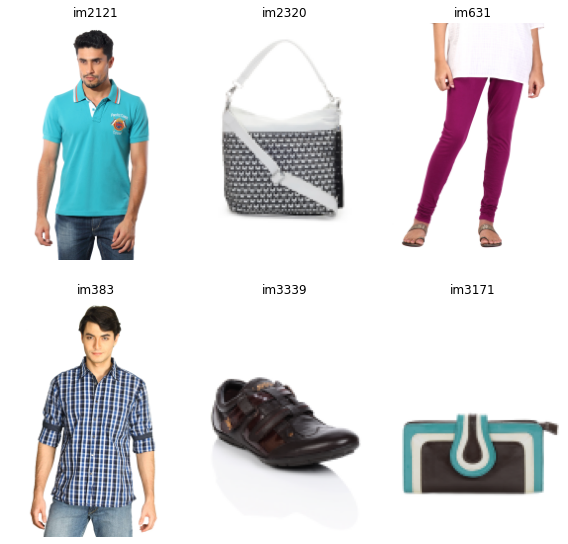

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# (tittle, images) dict 생성
figures = {'im'+str(i) : load_image(row.image) for i, row in df.sample(6).iterrows()}

# plot the images with 2 rows and 3 cols
plot_figures(figures,2,3)

* 데이터셋 구성 : 마켓에서 볼 수 있는 아이템들  
* 아이디어  
    임베딩을 이용해 이미지의 유사성을 계산하고 유사한 아이템들 찾기

<AxesSubplot:>

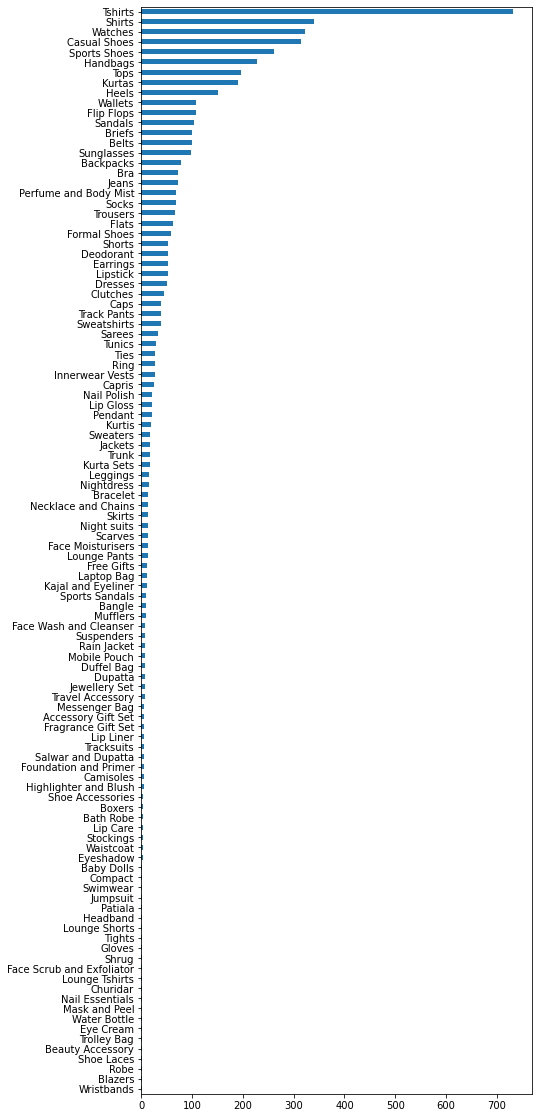

In [6]:
# 어떤 종류의 제품이 제일 많은지 탐색
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

## Use Pre-trained Model to Recommendation

In [7]:
import tensorflow as tf
import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.6.4'

In [8]:
load_image(df.iloc[0].image).shape

(240, 180, 3)

In [9]:
# Input shape
# load_image(df.iloc[0].image).shape
img_width, img_height, _ = 224,224,3

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
# transfer learning을 할 때에 베이스부분을 학습할 것인지 말것인지를 결정
# True로 하게 되면 베이스 모델의 파라미터를 미세하게 조절하게 됨 
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()


2022-10-28 17:50:02.282307: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
def get_embedding(model, img_name):
    # reshape
    img = image.load_img(img_path(img_name), target_size = (img_width, img_height))
    # img to array
    x = image.img_to_array(img)
    # expand dim (1,w,h)
    x = np.expand_dims(x,axis=0)
    # pre process input
    # 모델 형식에 맞게 변환
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [11]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

2022-10-28 17:50:08.378501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(2048,)

(240, 180, 3)
[ 5.661307   2.366157   0.        ...  1.3138657  0.        10.820532 ]


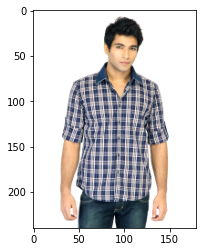

In [12]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [13]:
df.shape

(5000, 11)

In [14]:
# GET embedding for all items

df_sample = df
map_embeddings = df_sample['image'].apply(lambda img : get_embedding(model,img))
df_embs = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(5000, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.661307,2.366157,0.000000,3.255745,0.845214,2.673839,8.780895,6.280786,0.787186,1.587660,...,2.463607,0.000000,1.825990,20.485281,3.902868,0.000000,8.225988,1.313866,0.000000,10.820532
1,5.790409,9.593645,0.000000,9.431673,0.287240,0.259942,17.028765,3.037457,0.136345,0.000000,...,1.670576,0.013897,10.338687,4.784717,0.189141,0.000000,7.739139,0.372709,0.000000,8.903803
2,0.000000,3.162248,0.484689,0.172307,2.609551,3.840855,3.426144,0.253235,1.098894,1.418286,...,0.434925,14.092844,3.018757,2.134505,2.549047,0.377386,6.180365,0.636625,14.018163,11.415052
3,5.882219,1.958619,0.000000,12.519888,0.000000,0.000000,9.383587,3.781627,0.000000,1.490627,...,17.825491,0.000000,3.592508,2.042310,0.000000,0.000000,6.656786,1.457308,1.694212,1.403327
4,0.245965,17.383436,0.493823,3.374469,2.567368,0.000000,6.482541,5.862638,0.000000,3.164861,...,4.464013,0.447084,1.448139,12.884146,0.000000,0.397491,5.028077,1.939696,0.000000,11.485394


### Compute Similarity between itmes

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calculate Matrix Distance 
cosine_sim = 1-pairwise_distances(df_embs, metric = 'cosine')
cosine_sim[:4,:4]

array([[1.        , 0.7134498 , 0.4542724 , 0.6797062 ],
       [0.7134498 , 0.9999994 , 0.41515315, 0.83330894],
       [0.4542724 , 0.41515315, 0.99999905, 0.44629484],
       [0.6797062 , 0.83330894, 0.44629484, 0.9999997 ]], dtype=float32)

### Recommender Similar Items

In [16]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
# idx를 넣으면 df에 있는 것들과 코사인 유사도를 구하고
# 높은 순서대로 소팅 후 유사도와 인덱스 반환 
def get_recommender(idx, df, top_n = 5):
    sim_idx = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key =lambda x :x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec = [i[0] for i in sim_scores]
    idx_sim = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n =5)

(Int64Index([251, 659, 2400, 0, 1821], dtype='int64'),
 [0.9236281, 0.9223267, 0.91904205, 0.91508716, 0.9131173])

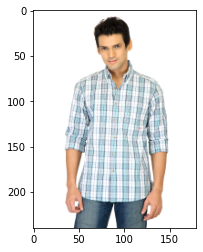

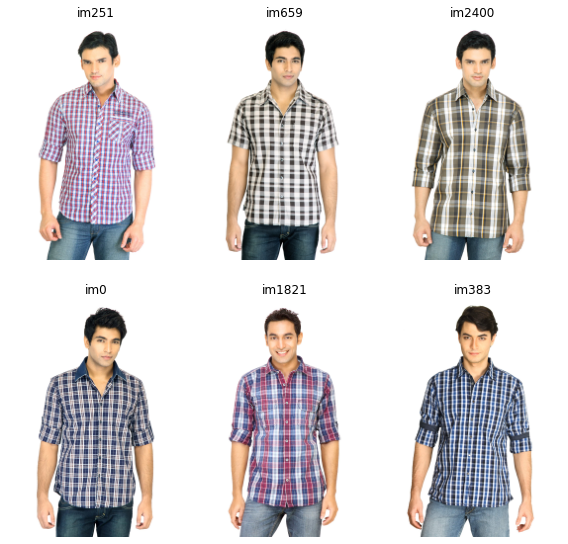

In [17]:
# Idx Item to Recommender
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [18]:
def show_result(idx_ref):
    # Recom
    idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)
    plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
    
    figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
    plot_figures(figures, 2, 3)

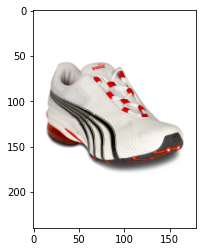

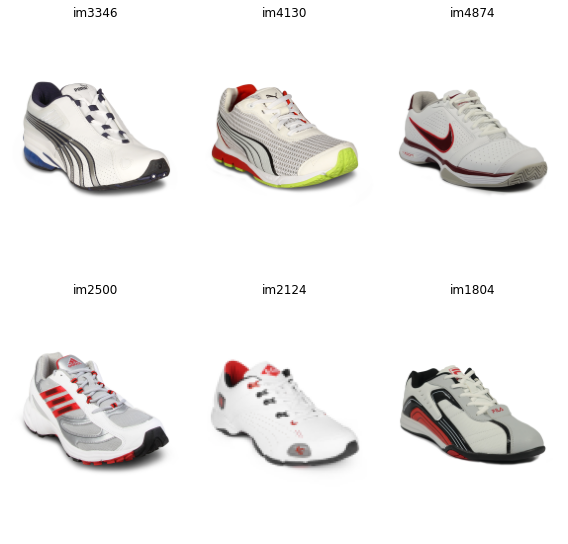

In [19]:
show_result(987)

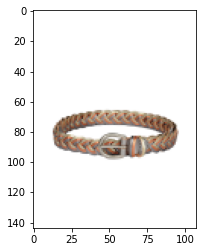

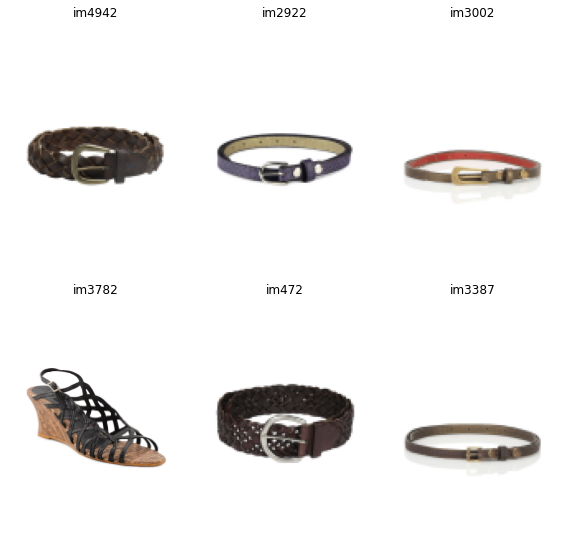

In [20]:
show_result(3524)

## Visualization latent space of contents

* TSNE를 이용해 차원 축소 

In [21]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [22]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


sklearn TSNE : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [23]:
time_start = time.time()
# n_components : n차원으로 축소
# perplexity : 가깝고 먼 것을 어떻게 대할 것인지. 100이면 멀든 가깝든 동일하게 취급함. 5-50 사이 추천
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 11.45425534248352 seconds


In [24]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

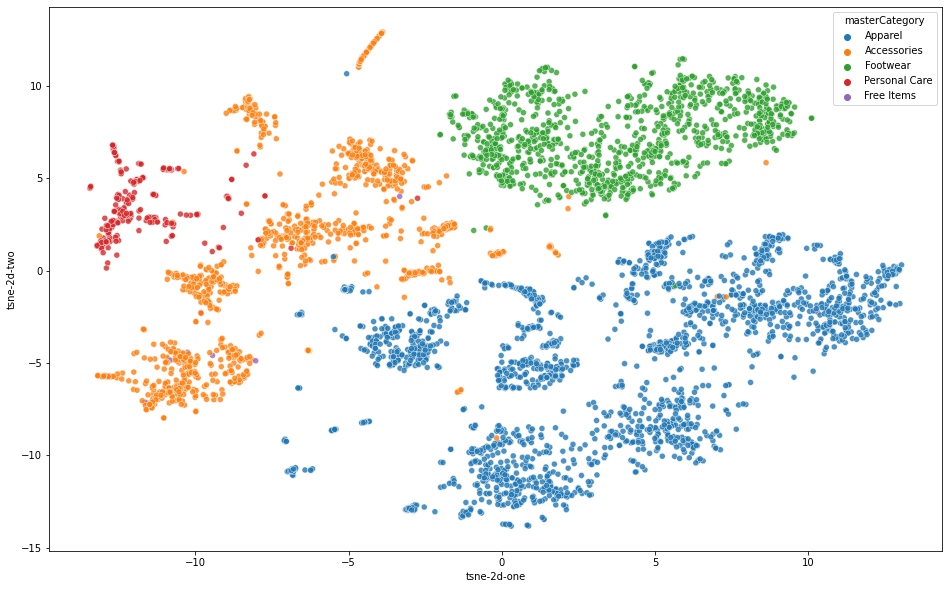

In [25]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

* 임베딩에 따라 생성된 서로 다른 클러스터들을 볼 수 있음 

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

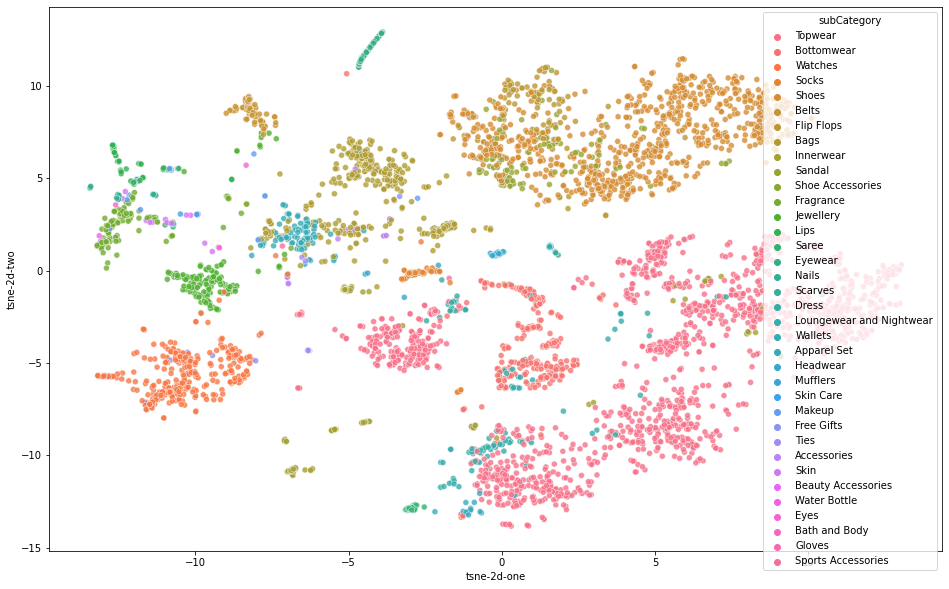

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

## Conclusion

CNN은 모든 콘텐츠의 일반적인 임베딩을 생성하는 데 사용될 수 있음.  
A big improvement would be to retrain some network layers in a dataset similar to the one that will be used. So the network learns better features for a specific problem.
